In [30]:
import math

from IPython import display
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd
from sklearn import metrics

import tensorflow as tf
from tensorflow.python.data import Dataset

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

In [38]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [44]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [32]:
def preprocess_features(california_housing_dataframe):
    """
    Creates synthetic features
    Args:
        Dataset
    Returns:
        feature columns
    """
    selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    processed_features['rooms_per_person'] = processed_features['total_rooms']/processed_features['population']
#     processed_features['rooms_per_person'] = processed_features['rooms_per_person'].apply(lambda x: min(5.0, x))
    return processed_features

In [14]:
def preprocess_targets(california_housing_dataframe):
    """
    Prepares targets
    Args:
    Returns:
    """
    targets = pd.DataFrame()
    targets['median_house_value'] = california_housing_dataframe['median_house_value']
    targets['median_house_value'] = targets['median_house_value']/1000
    return targets

In [45]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2662.3,541.7,1436.7,503.1,3.9,2.0
std,2.1,2.0,12.6,2258.9,430.4,1188.0,392.6,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.0,297.0,788.0,281.8,2.6,1.5
50%,34.2,-118.5,29.0,2134.5,435.0,1168.5,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3163.0,650.0,1720.0,606.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [46]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.0
std,116.1
min,15.0
25%,118.8
50%,178.8
75%,264.6
max,500.0


In [47]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2598.8,533.9,1412.5,496.7,3.9,2.0
std,2.1,2.0,12.5,1977.2,399.4,1045.2,364.4,1.9,1.1
min,32.5,-124.2,2.0,8.0,1.0,9.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1464.5,296.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2118.5,431.0,1164.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3131.5,644.2,1721.2,603.0,4.8,2.3
max,41.9,-114.6,52.0,26322.0,4952.0,12153.0,4616.0,15.0,41.3


In [150]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,208.1
std,115.8
min,15.0
25%,120.8
50%,182.8
75%,265.7
max,500.0


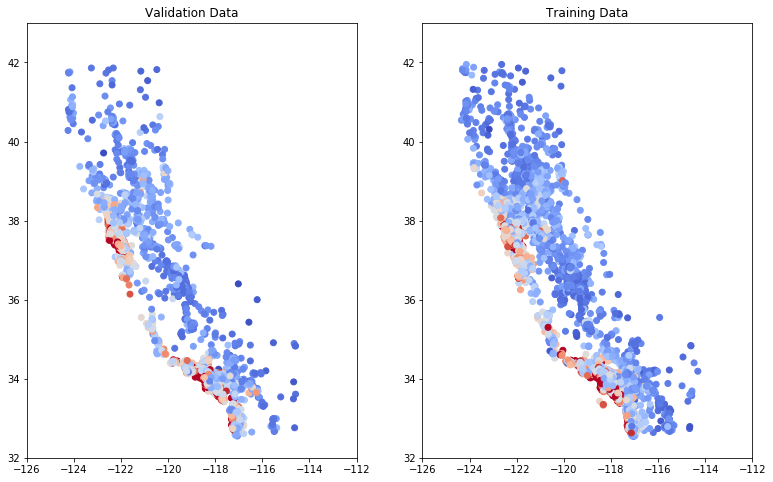

In [49]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

In [55]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features, targets = ds.make_one_shot_iterator().get_next()
    return features, targets

In [84]:
def my_predict_input_fn(features, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices(features)
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features = ds.make_one_shot_iterator().get_next()
    return features

In [51]:
def construct_feature_columns(input_features):
    """
    Constructs a set of tf feature columns
    Args:
    Returns:
    """
    return set([tf.feature_column.numeric_column(feature) for feature in input_features])
    

In [67]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'])
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], shuffle=False, num_epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets['median_house_value'], shuffle=False, num_epochs=1)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn = predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 217.36
  period 01 : 199.82
  period 02 : 186.35
  period 03 : 177.45
  period 04 : 172.18
  period 05 : 169.24
  period 06 : 168.00
  period 07 : 167.88
  period 08 : 169.68
  period 09 : 171.10
Model training finished.


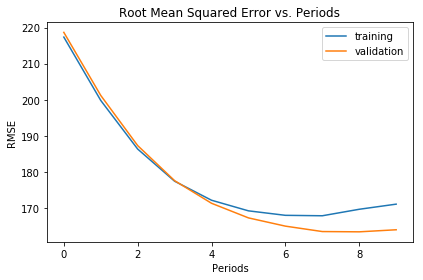

In [70]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [71]:
california_housing_test_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

In [72]:
tst_ftrs = preprocess_features(california_housing_test_data)

In [74]:
tst_trgt = preprocess_targets(california_housing_test_data)

In [109]:
predict_test_input_fn = lambda: my_predict_input_fn(tst_ftrs, shuffle=False, num_epochs=1)

In [114]:
tst_prds = linear_regressor.predict(input_fn=predict_test_input_fn)

In [111]:
tst_prds = np.array([item['predictions'][0] for item in tst_prds])

In [112]:
print('Test RMSE = {:.1f}'.format(math.sqrt(metrics.mean_squared_error(tst_trgt['median_house_value'], tst_prds))))

Test RMSE = 162.2


In [149]:
i=0
for item in tst_prds:
    print(item)
    i+=1
    if i>1:
        break